Data Split: Train=650, Validation=163


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


--- Training Complete ---
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

--- Training Set Performance ---
Accuracy    : 0.9369
Precision   : 0.9863
Recall      : 0.8862
F1-Score    : 0.9335
ROC-AUC     : 0.9851
Log-Loss    : 0.1569
Brier Score : 0.0458

--- Validation Set Performance ---
Accuracy    : 0.9325
Precision   : 0.9487
Recall      : 0.9136
F1-Score    : 0.9308
ROC-AUC     : 0.9857
Log-Loss    : 0.1500
Brier Score : 0.0463

Classification Report (Validation):
              precision    recall  f1-score   support

  Low YS (0)       0.92      0.95      0.93        82
 High YS (1)       0.95      0.91      0.93        81

    accuracy                           0.93       163
   macro avg       0.93      0.93      0.93       163
weighted avg       0.93      0.93      0.93       163



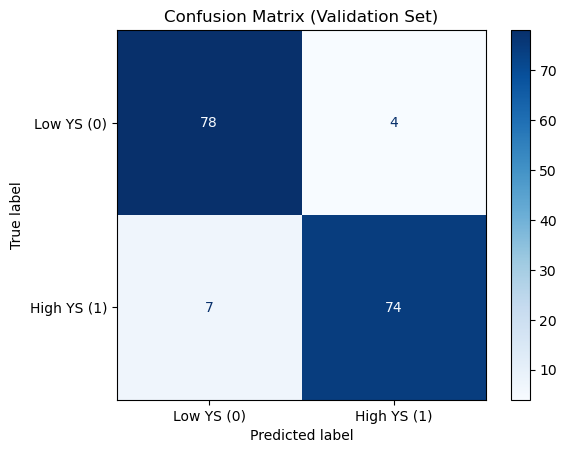

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Configuration ---
DATA_FILE = 'ys_classified.csv'
RANDOM_STATE = 42
DROPOUT_RATE = 0.3

def train_mlp_keras_dropout():
    if not os.path.exists(DATA_FILE):
        print(f"ERROR: The data file '{DATA_FILE}' was not found.")
        return

    # 1. Load Data
    df = pd.read_csv(DATA_FILE)
    ELEMENTAL_COLUMNS = ['W', 'Nb', 'Hf', 'Mo', 'Re', 'Zr', 'Ta', 'Ti', 'C', 'Y', 'Al', 'Si', 'V', 'Cr']
    PHYSICAL_COLUMN = ['Test temp']
    X = df[ELEMENTAL_COLUMNS + PHYSICAL_COLUMN]
    Y = df['YS_Class']

    # 2. Split Data (80% train, 20% validation)
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=0.2, random_state=RANDOM_STATE, stratify=Y
    )
    print(f"Data Split: Train={len(X_train)}, Validation={len(X_val)}")

    # 3. Feature Scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # 4. Model Architecture
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(DROPOUT_RATE),
        Dense(32, activation='relu'),
        Dropout(DROPOUT_RATE),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # 5. Compile Model
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 6. Early Stopping
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True
    )

    # 7. Train Model
    model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=500,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    print("--- Training Complete ---")

    # 8. Predictions
    Y_train_pred = (model.predict(X_train) > 0.5).astype(int)
    Y_val_pred = (model.predict(X_val) > 0.5).astype(int)

    Y_train_proba = model.predict(X_train).flatten()
    Y_val_proba = model.predict(X_val).flatten()

    # 9. Evaluation Function
    def evaluate(Y_true, Y_pred, Y_proba):
        return {
            "Accuracy": accuracy_score(Y_true, Y_pred),
            "Precision": precision_score(Y_true, Y_pred),
            "Recall": recall_score(Y_true, Y_pred),
            "F1-Score": f1_score(Y_true, Y_pred),
            "ROC-AUC": roc_auc_score(Y_true, Y_proba),
            "Log-Loss": log_loss(Y_true, Y_proba),
            "Brier Score": brier_score_loss(Y_true, Y_proba)
        }

    train_metrics = evaluate(Y_train, Y_train_pred, Y_train_proba)
    val_metrics = evaluate(Y_val, Y_val_pred, Y_val_proba)

    # 10. Display Results
    print("\n--- Training Set Performance ---")
    for metric, value in train_metrics.items():
        print(f"{metric:<12}: {value:.4f}")

    print("\n--- Validation Set Performance ---")
    for metric, value in val_metrics.items():
        print(f"{metric:<12}: {value:.4f}")

    print("\nClassification Report (Validation):")
    print(classification_report(Y_val, Y_val_pred, target_names=['Low YS (0)', 'High YS (1)']))

    # 11. Confusion Matrix (only visualization)
    cm = confusion_matrix(Y_val, Y_val_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low YS (0)', 'High YS (1)'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix (Validation Set)")
    plt.show()

    return model

if __name__ == "__main__":
    train_mlp_keras_dropout()
